In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests
import subprocess as sp
from scipy.stats.mstats import zscore

from scipy.stats import pearsonr, spearmanr

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
def hyper_test(M, n, N, k):
    '''
    Calculates the hypergeometric test.
    
    Input:
      M: Population size (total exons tested)
      n: Successess in population (exons with p-value <= x)
      N: Sample size (exons selected)
      k: Successes in sample (selected exons with p-value <= x)
    Output:
      p_depleted: p-value of depletion from the hypergeometric test
      p_enriched: p-value of enrichment from the hypergeometric test
    '''
    hpd = hypergeom(M, n, N) # Hypergeometric distribution
    p_depleted = hpd.cdf(k)  # Get cummulative distribution up to k
    p_enriched = hpd.sf(k-1) # Survival function up to k-1 (1 - cdf(k-1))
    return p_depleted, p_enriched


def test_enrichment(binding, exon_cluster):
    M = len(binding)
    n = binding.sum()
    N = len(exon_cluster)
    k = binding.loc[exon_cluster].sum()
    p_depleted, p_enriched = hyper_test(M, n, N, k)
    
    enrichment = (k/N)/(n/M)
    
    if enrichment == 0:
        log_enrich = -3
    else:
        log_enrich = np.log2(enrichment)
        
    
    return p_enriched, p_depleted, log_enrich

from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm


In [3]:
psix_results = pd.read_csv('psix_3D/psix_results.tab.gz', sep='\t', index_col=0)
modules = pd.read_csv('psix_3D/modules_3D.tab.gz', sep='\t', index_col=0).Module
psi =  pd.read_csv('data/preprocess/tables/psi_3D.tab.gz', sep='\t', index_col=0)
mrna_per_event =  pd.read_csv('data/preprocess/tables/mrna_per_event_3D.tab.gz', sep='\t', index_col=0)
neighbors_psi = pd.read_csv('data/preprocess/tables/neighbors_psi_3D.tab.gz', sep='\t', index_col=0)
latent = pd.read_csv('data/preprocess/tables/pc3_rd.tab.gz', sep='\t', index_col=0)
norm_expression = pd.read_csv('data/preprocess/tables/scone_norm_tpm_extended.tab.gz', sep='\t', index_col=0)[latent.index]

from sklearn.preprocessing import StandardScaler
# scaled_counts = pd.DataFrame(StandardScaler().fit_transform(norm_expression.T).T)
# scaled_counts.index = norm_expression.index
# scaled_counts.columns = norm_expression.columns

meta = pd.read_csv('data/SraRunTable.txt.gz', index_col=0).loc[latent.index]

p90_cells = meta.loc[meta.Age == 'postnatal day 90'].index 
p1_cells = meta.loc[meta.Age == 'postnatal day 1'].index 
e18_cells = meta.loc[meta.Age == 'embryonic day 18.5'].index 
e15_cells = meta.loc[meta.Age == 'embryonic day 15.5'].index 
e13_cells = meta.loc[meta.Age == 'embryonic day 13.5'].index 

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


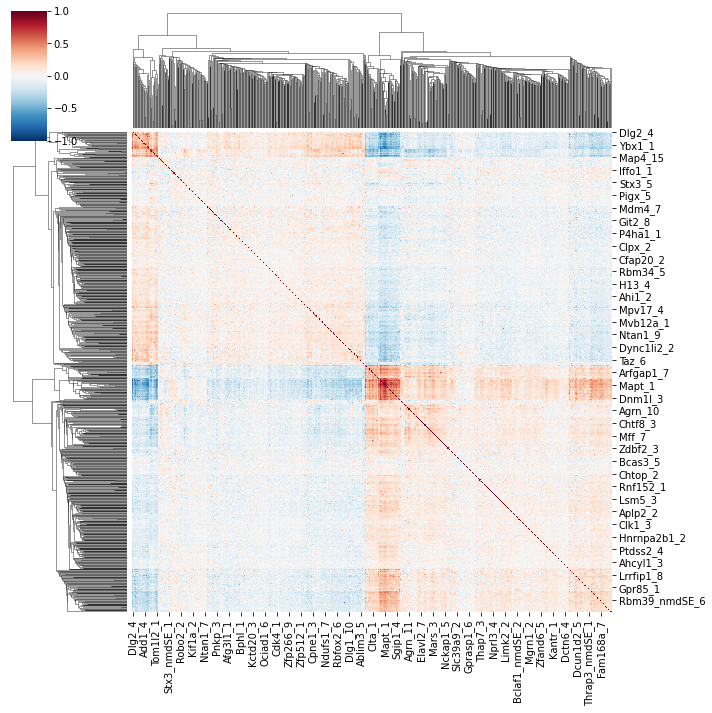

In [4]:
sns.clustermap(psi.loc[psix_results.index[psix_results.qvals <= 0.05]].T.corr().fillna(0), 
               cmap='RdBu_r', vmin=-1, vmax=1)

In [5]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
mouse_clip_peaks = mouse_clip_peaks[[x for x in mouse_clip_peaks.columns if x != 'AGO2']]
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']

In [7]:
sig_exons = psix_results.loc[(psix_results.qvals <= 0.05) & (psix_results.psix_score > 0)].index

pval_hyper = pd.DataFrame(np.zeros((4, 32)), columns = mouse_clip_peaks.columns, index = ['e1', 's1', 's2', 'e2'])
enrichment_hyper = pd.DataFrame(np.zeros((4, 32)), columns = mouse_clip_peaks.columns, index = ['e1', 's1', 's2', 'e2'])

for RBP in mouse_clip_peaks.columns:
    for region in ['e1', 's1', 's2', 'e2']:
        
        region_exons = [x for x in mouse_clip_peaks.index if x[-3:]==('_' + region)]
        
        hyper = test_enrichment(mouse_clip_peaks.loc[region_exons, RBP], [x + '_' + region for x in sig_exons])
        pval_hyper.loc[region, RBP] = hyper[0]
        enrichment_hyper.loc[region, RBP] = hyper[2]

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


In [8]:
pval_hyper

,PTBP1,SRSF1,MBNL1MBNL2,LIN28A,FMR1,SRRM4,RBM3,RBFOX3,MBNL1,ELAVL1,...,FUS,EZH2,RBFOX2,CELF1,SRSF4,TAF15,RBFOX1,CIRBP,UPF1,SRSF3
e1,1.000000,0.000311,0.074874,0.000004,0.818590,0.036172,0.477252,0.041448,0.639758,1.000000,...,8.440809e-17,0.028075,0.000064,0.818590,0.000126,0.791277,6.822286e-04,0.000024,0.433677,0.005015
s1,1.000000,0.185060,0.146033,0.033332,0.315465,0.153000,0.277580,0.000249,0.009855,1.000000,...,5.919854e-15,0.079041,0.000002,0.104167,0.001066,0.734820,1.063461e-03,0.023523,0.346945,0.156868
s2,0.679409,0.052765,0.173394,0.157031,0.172615,0.391549,0.684289,0.004273,1.000000,1.000000,...,2.025521e-12,0.477252,0.000001,0.192237,0.017508,0.477252,3.436455e-08,0.054532,0.477252,0.398878
e2,1.000000,0.081486,0.070440,0.000042,0.241408,0.038147,0.002905,0.025219,0.186701,0.315465,...,6.221915e-18,0.104167,0.000290,0.734820,0.000070,0.165614,1.610216e-03,0.062606,1.000000,0.013501


In [9]:
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(pval_hyper).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(4,-32),#<=0.1,
                                        columns = mouse_clip_peaks.columns, index = ['e1', 's1', 's2', 'e2'])

In [12]:
sorted(pval_hyper.columns[(multipletests(np.array(pval_hyper).reshape(1,-1)[0],  method='fdr_bh')[1].reshape(4,-32) <= 0.05).sum(axis=0) > 0])

['CELF4',
 'CIRBP',
 'FUS',
 'LIN28A',
 'MBNL1',
 'MBNL2',
 'NOVA1',
 'NOVA2',
 'PTBP2',
 'RBFOX1',
 'RBFOX2',
 'RBFOX3',
 'RBM3',
 'SRSF1',
 'SRSF2',
 'SRSF3',
 'SRSF4',
 'SRSF5',
 'SRSF6',
 'SRSF7',
 'TARDBP',
 'U2AF2']

In [11]:
from scipy.stats import pearsonr, spearmanr
def nan_pearsonr(x, y):
    non_nan = y.dropna().index
    if len(non_nan) < 15:
        return (np.nan, 1)
    return pearsonr(x.loc[non_nan], y.loc[non_nan])

In [11]:
sf_list = ['Celf4', 'Cirbp', 'Fus', 'Lin28a', 'Mbnl1', 'Mbnl2', 'Nova1', 'Nova2', 'Ptbp1', 'Ptbp2',
           'Rbfox1', 'Rbfox2', 'Rbfox3', 'Srsf1', 'Srsf2', 'Srsf3', 'Srsf4', 'Srsf6', 'Srsf7', 'Tardbp', 'U2af2']
sf_list = [x for x in sf_list if x in norm_expression.index]

sf_list2 = ['Celf1', 'Elavl1', 'Ezh2', 'Fmr1', 'Pabpc1', 'Srrm4', 'Taf15', 'Upf1']
sf_list2 = [x for x in sf_list2 if x in norm_expression.index]



pearsonr_pos_list = []
pearsonr_neg_list = []
for exon in tqdm(sig_exons, position= 0, leave=True):
    for sf in sf_list:
        pearsonr_pos_list.append(
            nan_pearsonr(
                norm_expression.loc[sf], psi.loc[exon]
            )
        )
        
    for sf in sf_list2:
        pearsonr_neg_list.append(
            nan_pearsonr(
                norm_expression.loc[sf], psi.loc[exon]
            )
        )
        

100%|██████████| 798/798 [00:44<00:00, 17.79it/s]


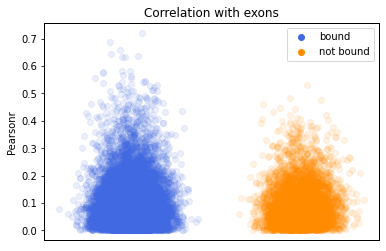

In [10]:
plt.scatter(np.random.normal(0, 0.1, 15960), [np.abs(x[0]) for x in pearsonr_pos_list], alpha=0.1, c='royalblue')
plt.scatter([0], [0.05], c='royalblue', label='bound')

plt.scatter(np.random.normal(1, 0.1, 6384), [np.abs(x[0]) for x in pearsonr_neg_list], alpha=0.1, c='darkorange')
plt.scatter([1], [0.05], c='darkorange', label='not bound')

plt.xticks([])
plt.ylabel('Pearsonr')
plt.title('Correlation with exons')
plt.legend()
plt.show()

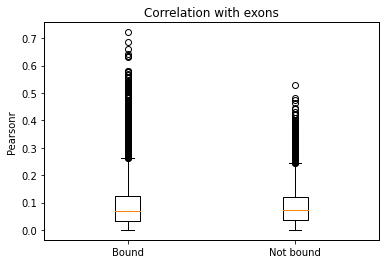

In [11]:
plt.boxplot([[np.abs(x[0]) for x in pearsonr_pos_list], [np.abs(x[0]) for x in pearsonr_neg_list]])
plt.xticks([1, 2], ['Bound', 'Not bound'])
plt.ylabel('Pearsonr')
plt.title('Correlation with exons')
# plt.legend()
plt.show()


In [12]:
len([np.abs(x[0]) for x in pearsonr_pos_list])

15960

100%|██████████| 20/20 [00:00<00:00, 61.72it/s]


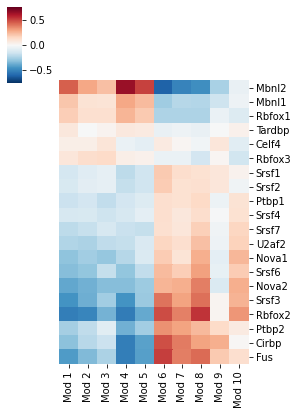

In [12]:
module_avg = pd.DataFrame()


sf_list = ['Celf4', 'Cirbp', 'Fus', 'Lin28a', 'Mbnl1', 'Mbnl2', 'Nova1', 'Nova2', 'Ptbp1', 'Ptbp2',
           'Rbfox1', 'Rbfox2', 'Rbfox3', 'Srsf1', 'Srsf2', 'Srsf3', 'Srsf4', 'Srsf6', 'Srsf7', 'Tardbp', 'U2af2']

sf_list = [x for x in sf_list if x in norm_expression.index]

for mod in range(1, 11):
    module_avg['module_' + str(mod)] = np.nanmean(zscore(psi.loc[modules.index[modules == mod]], axis=1, 
                                             nan_policy='omit'), axis=0)
    
module_avg.index = psi.columns
module_avg = module_avg.T


module_avg_corr = pd.DataFrame(np.zeros((len(sf_list), len(module_avg.index))), 
                               index = sf_list, columns = module_avg.index)
for sf in tqdm(sf_list):
    for mod in module_avg.index:
        module_avg_corr.loc[sf, mod] = pearsonr(module_avg.loc[mod],
                                                norm_expression.loc[sf, module_avg.columns]
        )[0]
        
mod_order = ['module_1', 'module_2', 'module_3', 'module_4', 'module_5',
             'module_6', 'module_7', 'module_8', 'module_9', 'module_10']

mod_cor = module_avg_corr.loc[sf_list, mod_order]
mod_cor.columns = ['Mod 1', 'Mod 2', 'Mod 3', 'Mod 4', 'Mod 5',
             'Mod 6', 'Mod 7', 'Mod 8', 'Mod 9', 'Mod 10']

cg = sns.clustermap(mod_cor, 
               col_cluster=False,
#               row_colors = gene_mod_colors, 
               row_cluster=True, vmin=-0.75, vmax=0.75, cmap='RdBu_r', figsize=(10/2.4, 14/2.4))

cg.ax_row_dendrogram.set_visible(False)

# plt.show()
plt.savefig('plots/module_correlations.png', bbox_inches='tight', res=20000, dpi =2000)

In [13]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']

new_idx = [x[:-3] for x in mouse_clip_peaks.index if x[-3:] == '_e1']
mouse_clip_peaks_e1 = mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:] == '_e1']]
mouse_clip_peaks_s1 = mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:] == '_s1']]
mouse_clip_peaks_s2 = mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:] == '_s2']]
mouse_clip_peaks_e2 = mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:] == '_e2']]

mouse_clip_peaks_e1.index = new_idx
mouse_clip_peaks_s1.index = new_idx
mouse_clip_peaks_s2.index = new_idx
mouse_clip_peaks_e2.index = new_idx

mouse_clip_peaks_any = ((mouse_clip_peaks_e1 + mouse_clip_peaks_s1 + mouse_clip_peaks_s2 + mouse_clip_peaks_e2) > 0).astype(int)


modules = pd.read_csv('psix_3D/modules_3D.tab.gz', sep='\t', index_col=0).Module

# AGO2, EZH2, LIN28A, CIRBP, FMR1, TAF15, UPF1
remove = ['EZH2', 'AGO2', 'LIN28A', 'CIRBP', 'FMR1', 'TAF15', 'UPF1']
splicing_factors =  [x for x in mouse_clip_peaks_any.columns if x not in remove]

mouse_clip_peaks_any[splicing_factors]

sig_exons = psix_results.loc[(psix_results.qvals <= 0.05) & (psix_results.psix_score > 0)].index

pval_hyper = []
enrichment_hyper = []

for RBP in splicing_factors:
        
    region_exons = mouse_clip_peaks_any.index

    hyper = test_enrichment(mouse_clip_peaks_any.loc[psix_results.index, RBP], sig_exons)
    pval_hyper.append(hyper[0])
    enrichment_hyper.append(hyper[2])

(array([17.,  1.,  1.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([2.36204165e-22, 4.27369711e-02, 8.54739422e-02, 1.28210913e-01,
        1.70947884e-01, 2.13684855e-01, 2.56421827e-01, 2.99158798e-01,
        3.41895769e-01, 3.84632740e-01, 4.27369711e-01, 4.70106682e-01,
        5.12843653e-01, 5.55580624e-01, 5.98317595e-01, 6.41054566e-01,
        6.83791537e-01, 7.26528508e-01, 7.69265480e-01, 8.12002451e-01,
        8.54739422e-01]),
 <a list of 20 Patch objects>)

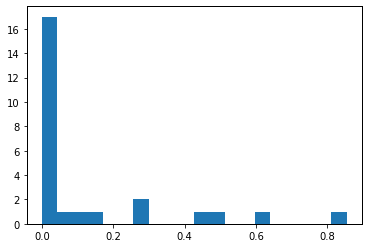

In [14]:
plt.hist(pval_hyper, bins=20)

(array([16.,  1.,  1.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([2.36204165e-22, 4.27369711e-02, 8.54739422e-02, 1.28210913e-01,
        1.70947884e-01, 2.13684855e-01, 2.56421827e-01, 2.99158798e-01,
        3.41895769e-01, 3.84632740e-01, 4.27369711e-01, 4.70106682e-01,
        5.12843653e-01, 5.55580624e-01, 5.98317595e-01, 6.41054566e-01,
        6.83791537e-01, 7.26528508e-01, 7.69265480e-01, 8.12002451e-01,
        8.54739422e-01]),
 <a list of 20 Patch objects>)

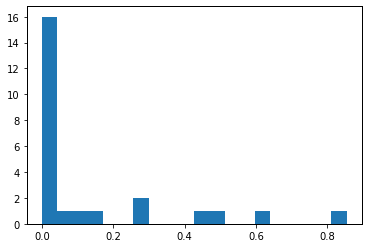

In [14]:
plt.hist(pval_hyper, bins=20)

In [15]:
sorted(np.array(splicing_factors)[multipletests(pval_hyper, method='fdr_bh')[0]])

['CELF4',
 'FUS',
 'MBNL1MBNL2',
 'MBNL2',
 'NOVA1',
 'NOVA2',
 'PTBP2',
 'RBFOX1',
 'RBFOX2',
 'RBFOX3',
 'SRSF3',
 'SRSF4',
 'SRSF5',
 'SRSF6',
 'TARDBP',
 'U2AF2']

100%|██████████| 15/15 [00:00<00:00, 54.45it/s]


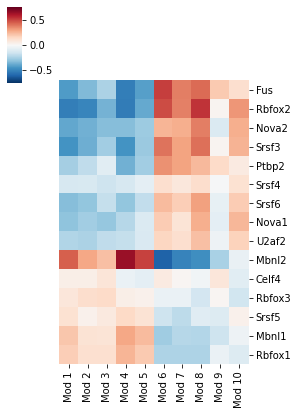

In [16]:
module_avg = pd.DataFrame()


sf_list = ['Celf4', 'Fus', 'Mbnl1', 'Mbnl2', 'Nova1', 'Nova2', 'Ptbp2',
           'Rbfox1', 'Rbfox2', 'Rbfox3', 'Srsf3', 'Srsf4', 'Srsf5', 
           'Srsf6', 'Tardp', 'U2af2'
           ]

# ['Celf4', 'Cirbp', 'Fus', 'Lin28a', 'Mbnl1', 'Mbnl2', 'Nova1', 'Nova2', 'Ptbp1', 'Ptbp2',
#            'Rbfox1', 'Rbfox2', 'Rbfox3', 'Srsf1', 'Srsf2', 'Srsf3', 'Srsf4', 'Srsf6', 'Srsf7', 'Tardbp', 'U2af2']

sf_list = [x for x in sf_list if x in norm_expression.index]

for mod in range(1, 11):
    module_avg['module_' + str(mod)] = np.nanmean(zscore(psi.loc[modules.index[modules == mod]], axis=1, 
                                             nan_policy='omit'), axis=0)
    
module_avg.index = psi.columns
module_avg = module_avg.T


module_avg_corr = pd.DataFrame(np.zeros((len(sf_list), len(module_avg.index))), 
                               index = sf_list, columns = module_avg.index)
for sf in tqdm(sf_list):
    for mod in module_avg.index:
        module_avg_corr.loc[sf, mod] = pearsonr(module_avg.loc[mod],
                                                norm_expression.loc[sf, module_avg.columns]
        )[0]
        
mod_order = ['module_1', 'module_2', 'module_3', 'module_4', 'module_5',
             'module_6', 'module_7', 'module_8', 'module_9', 'module_10']

mod_cor = module_avg_corr.loc[sf_list, mod_order]
mod_cor.columns = ['Mod 1', 'Mod 2', 'Mod 3', 'Mod 4', 'Mod 5',
             'Mod 6', 'Mod 7', 'Mod 8', 'Mod 9', 'Mod 10']

cg = sns.clustermap(mod_cor, 
               col_cluster=False,
#               row_colors = gene_mod_colors, 
               row_cluster=True, vmin=-0.75, vmax=0.75, cmap='RdBu_r', figsize=(10/2.4, 14/2.4))

cg.ax_row_dendrogram.set_visible(False)

plt.show()
# plt.savefig('plots/module_correlations.png', bbox_inches='tight', res=20000, dpi =2000)

In [17]:
module_avg_corr.loc[module_avg_corr.abs().max(axis=1) >= 0.25]

,module_1,module_2,module_3,module_4,module_5,module_6,module_7,module_8,module_9,module_10
Fus,-0.424790,-0.329244,-0.238028,-0.520196,-0.414388,0.517731,0.383601,0.426396,0.195363,0.125225
Mbnl1,0.209364,0.110829,0.104775,0.289156,0.236100,-0.264366,-0.213823,-0.222506,-0.157202,-0.037410
Mbnl2,0.449820,0.289965,0.227993,0.647359,0.510116,-0.606928,-0.503464,-0.465307,-0.244810,-0.057916
Nova1,-0.302626,-0.262715,-0.289535,-0.215313,-0.105871,0.189965,0.101657,0.269579,-0.072627,0.246516
Nova2,-0.390111,-0.360370,-0.318794,-0.321393,-0.269602,0.257083,0.274491,0.381440,-0.106765,0.273654
Rbfox1,0.186924,0.118223,0.119195,0.253145,0.198357,-0.233186,-0.231936,-0.230222,-0.051927,-0.103734
Rbfox2,-0.520889,-0.497520,-0.353544,-0.526106,-0.383329,0.488287,0.378893,0.539525,0.021947,0.330962
Srsf3,-0.448047,-0.366831,-0.262315,-0.445885,-0.280777,0.406495,0.304238,0.410292,0.021875,0.257866
Srsf6,-0.317865,-0.293312,-0.181474,-0.293366,-0.183684,0.238073,0.184834,0.305125,-0.060518,0.193044


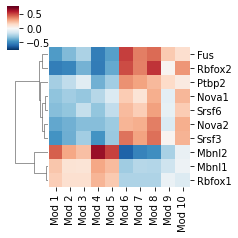

In [17]:
module_avg_corr.columns = ['Mod 1', 'Mod 2', 'Mod 3', 'Mod 4', 'Mod 5',
             'Mod 6', 'Mod 7', 'Mod 8', 'Mod 9', 'Mod 10']

sns.clustermap(module_avg_corr.loc[module_avg_corr.abs().max(axis=1) >= 0.25], 
               col_cluster=False,
#               row_colors = gene_mod_colors, 
               row_cluster=True, vmin=-0.75, vmax=0.75, cmap='RdBu_r', figsize=(8/2.4, 8/2.4))
plt.savefig('plots/module_correlations_small.png', bbox_inches='tight', res=20000, dpi =2000)

In [21]:
# list(plt.get_cmap('tab10').colors)

In [22]:
# module_avg_corr.columns = ['Mod 1', 'Mod 2', 'Mod 3', 'Mod 4', 'Mod 5',
#              'Mod 6', 'Mod 7', 'Mod 8', 'Mod 9', 'Mod 10']

# sns.clustermap(module_avg_corr.loc[module_avg_corr.abs().max(axis=1) >= 0.25], 
#                col_cluster=False,
#               col_colors = list(plt.get_cmap('tab10').colors), 
#                row_cluster=True, vmin=-0.75, vmax=0.75, cmap='RdBu_r', figsize=(8/2.4, 8/2.4))
# plt.savefig('plots/module_correlations_small.png', bbox_inches='tight', res=20000, dpi =2000)

100%|██████████| 8/8 [00:00<00:00, 51.26it/s]


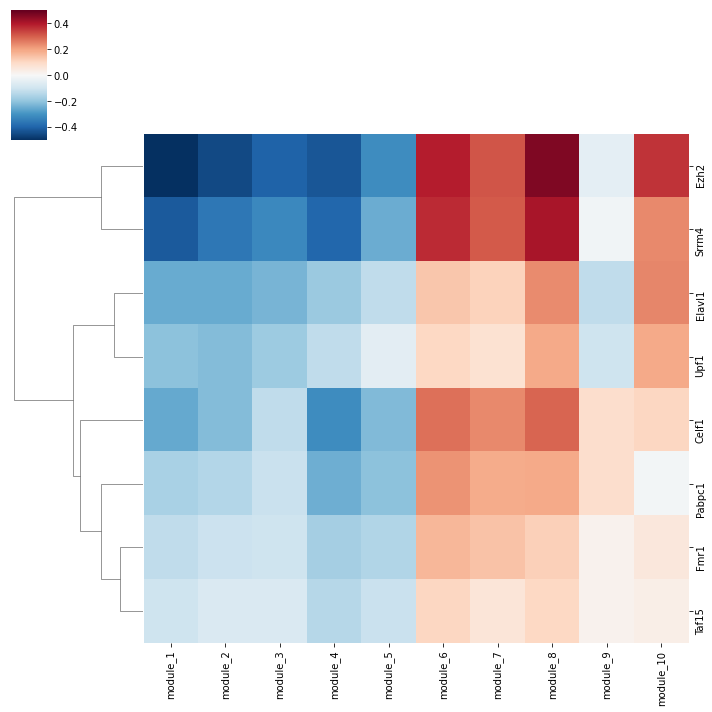

In [46]:
module_avg = pd.DataFrame()

sf_list2 = ['Celf1', 'Elavl1', 'Ezh2', 'Fmr1', 'Pabpc1', 'Srrm4', 'Taf15', 'Upf1']

sf_list2 = [x for x in sf_list2 if x in norm_expression.index]

for mod in range(1, 11):
    module_avg['module_' + str(mod)] = np.nanmean(zscore(psi.loc[modules.index[modules == mod]], axis=1, 
                                             nan_policy='omit'), axis=0)
    
module_avg.index = psi.columns
module_avg = module_avg.T


module_avg_corr = pd.DataFrame(np.zeros((len(sf_list2), len(module_avg.index))), 
                               index = sf_list2, columns = module_avg.index)
for sf in tqdm(sf_list2):
    for mod in module_avg.index:
        module_avg_corr.loc[sf, mod] = pearsonr(module_avg.loc[mod],
                                                norm_expression.loc[sf, module_avg.columns]
        )[0]
        
# module_avg_corr = pd.DataFrame(np.zeros((len(sf_neighbors.index), len(module_avg.index))), 
#                                index = sf_neighbors.index, columns = module_avg.index)
# for sf in tqdm(sf_neighbors.index):
#     for mod in module_avg.index:
#         module_avg_corr.loc[sf, mod] = pearsonr(module_avg.loc[mod],
#                                                 norm_expression.loc[sf, module_avg.columns]
#         )[0]

mod_order = ['module_1', 'module_2', 'module_3', 'module_4', 'module_5',
             'module_6', 'module_7', 'module_8', 'module_9', 'module_10']
sns.clustermap(module_avg_corr.loc[sf_list2, mod_order], 
               col_cluster=False,
#               row_colors = gene_mod_colors, 
               row_cluster=True, vmin=-0.5, vmax=0.5, cmap='RdBu_r')

plt.show()
# plt.savefig('plots/exon_modules.png', bbox_inches='tight', res=20000, dpi =2000)

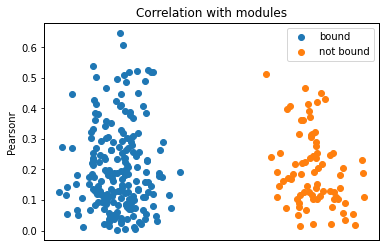

In [40]:
plt.scatter(np.random.normal(0, 0.1, 200), mod_cor.abs(), label='bound')

plt.scatter(np.random.normal(1, 0.1, 80), module_avg_corr.abs(), label='not bound')

plt.xticks([])
plt.ylabel('Pearsonr')
plt.title('Correlation with modules')
plt.legend()
plt.show()

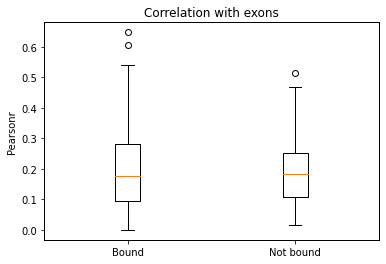

In [45]:
plt.boxplot([np.array(mod_cor.abs()).reshape(200,), np.array(module_avg_corr.abs()).reshape(80,)])
plt.xticks([1, 2], ['Bound', 'Not bound'])
plt.ylabel('Pearsonr')
plt.title('Correlation with exons')
# plt.legend()
plt.show()


100%|██████████| 8/8 [00:00<00:00, 52.80it/s]


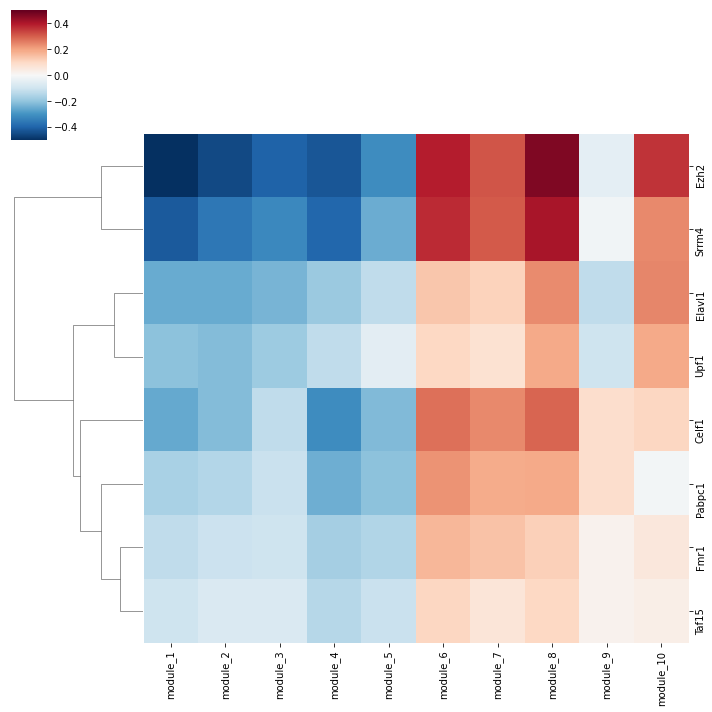

In [12]:
module_avg_corr

,module_1,module_2,module_3,module_4,module_5,module_6,module_7,module_8,module_9,module_10
Celf1,-0.253977,-0.218003,-0.125171,-0.313144,-0.221217,0.275176,0.238707,0.289125,0.089795,0.108463
Elavl1,-0.252284,-0.252432,-0.232109,-0.185705,-0.125421,0.138885,0.117085,0.236972,-0.128733,0.243886
Ezh2,-0.513476,-0.449351,-0.406012,-0.429527,-0.315481,0.392650,0.314352,0.467033,-0.049200,0.362638
Fmr1,-0.126054,-0.106973,-0.103624,-0.170365,-0.152092,0.167866,0.147061,0.117487,0.020513,0.055806
Pabpc1,-0.160668,-0.145938,-0.110685,-0.242836,-0.205998,0.224310,0.184154,0.191228,0.089299,-0.015097
Srrm4,-0.419191,-0.360222,-0.321334,-0.397419,-0.248416,0.371574,0.306368,0.413031,-0.017459,0.240485
Taf15,-0.102650,-0.074375,-0.076435,-0.140628,-0.111445,0.109178,0.065501,0.103203,0.021170,0.033203
Upf1,-0.206149,-0.217404,-0.180116,-0.127910,-0.053211,0.103257,0.076796,0.190669,-0.104431,0.188140


In [11]:
sig_exons = psix_results.loc[(psix_results.qvals <= 0.05) & (psix_results.psix_score > 0)].index

mod_list = []
for i in range(1, 11):
    for j in ['e1', 's1', 's2', 'e2']:
        mod_list.append('module_' + str(i) + '_' + j)

pval_hyper = pd.DataFrame(np.zeros((40, 31)), columns = mouse_clip_peaks.columns, index = mod_list)
enrichment_hyper = pd.DataFrame(np.zeros((40, 31)), columns = mouse_clip_peaks.columns, index = mod_list)

for RBP in tqdm(mouse_clip_peaks.columns, position=0, leave=True):
    
    for i in range(1, 11):
    
        for region in ['e1', 's1', 's2', 'e2']:
            
            mod_exons = modules.index[modules == i]
        
            region_exons = [x for x in mouse_clip_peaks.index if x[-3:]==('_' + region)]

            hyper = test_enrichment(mouse_clip_peaks.loc[region_exons, RBP], [x + '_' + region for x in mod_exons])
            
            mod_name = 'module_' + str(i) + '_' + region
            
            pval_hyper.loc[mod_name, RBP] = hyper[0]
            enrichment_hyper.loc[mod_name, RBP] = hyper[2]

100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


In [12]:
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(pval_hyper).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(40,-31),#<=0.1,
                                        columns = mouse_clip_peaks.columns, index = mod_list)

In [13]:
bound_rbps = sorted(hyper_enrich_significance.columns[(hyper_enrich_significance <= 0.05).sum() >= 1])

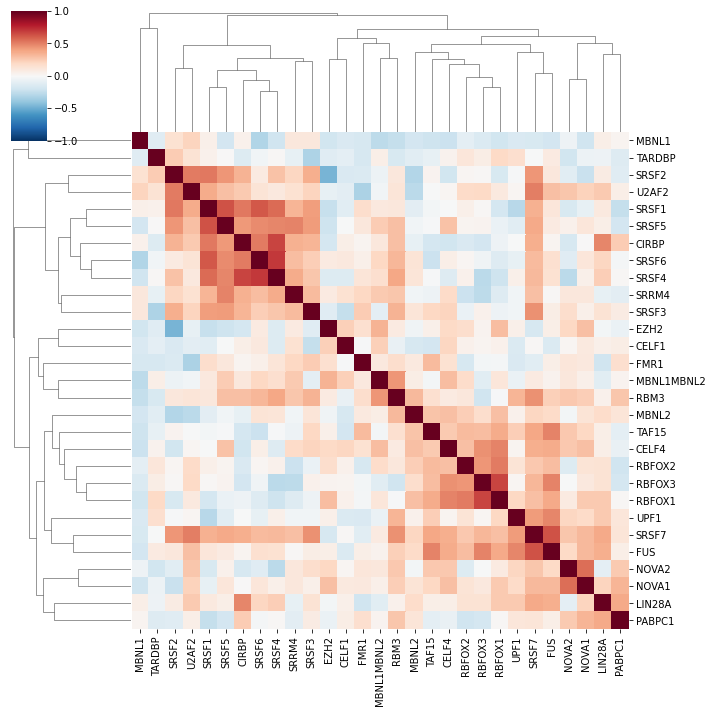

In [14]:
sns.clustermap(enrichment_hyper.T.dropna().T.corr(), cmap='RdBu_r', vmin=-1)

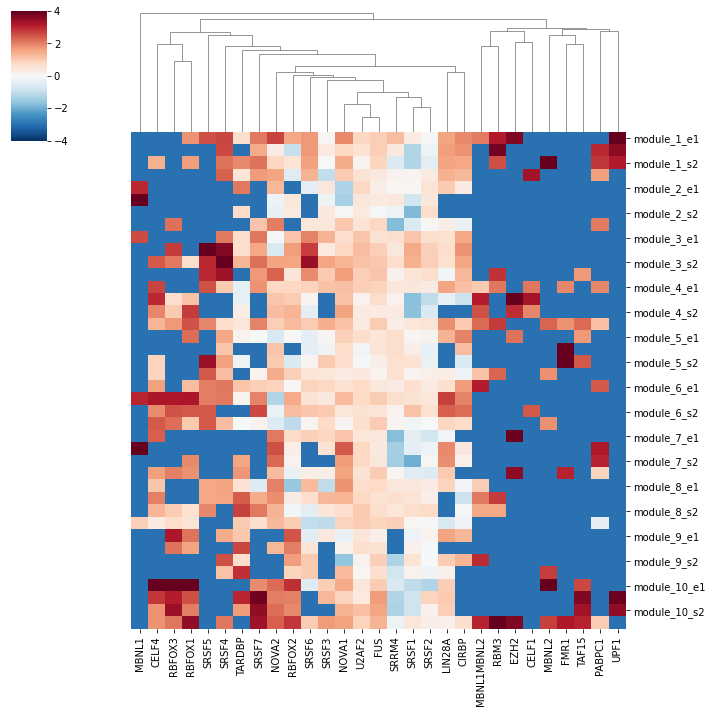

In [15]:
sns.clustermap(enrichment_hyper.T.dropna().T, cmap='RdBu_r', vmax=4, vmin=-4, row_cluster=False)

In [16]:
sf_list = ['Celf4', 'Cirbp', 'Fus', 'Lin28a', 'Mbnl1', 'Mbnl2', 'Nova1', 'Nova2', 'Ptbp1', 'Ptbp2',
           'Rbfox1', 'Rbfox2', 'Rbfox3', 'Srsf1', 'Srsf2', 'Srsf3', 'Srsf4', 'Srsf6', 'Srsf7', 'Tardbp', 'U2af2',
          
          'Celf1', 'Elavl1', 'Ezh2', 'Fmr1', 'Pabpc1', 'Srrm4', 'Taf15', 'Upf1']

sf_list = [x for x in sf_list if x in norm_expression.index]

In [17]:
expressed = norm_expression.loc[norm_expression.mean(axis=1) >= norm_expression.mean(axis=1).quantile(0.1)].index

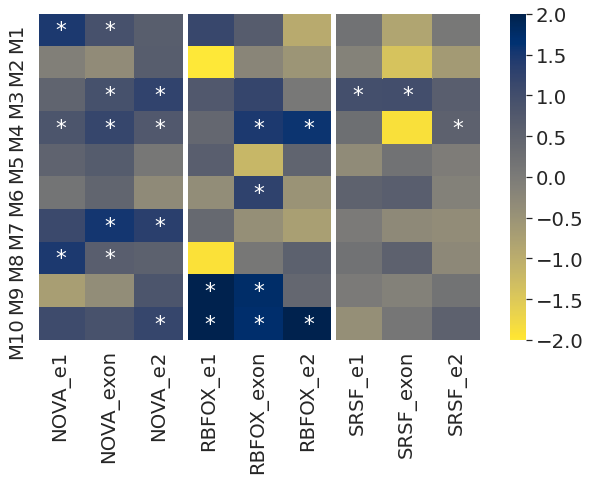

In [20]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
s1 = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
s2 = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_exon'] = ((s1+s2) > 0).astype(int)
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
s1 = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
s2 = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_exon'] = ((s1+s2) > 0).astype(int)
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF1', 'SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
s1 = np.array(mouse_clip_peaks.loc[s1_exons, ['SRSF1', 'SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
s2 = np.array(mouse_clip_peaks.loc[s2_exons, ['SRSF1', 'SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_exon'] = ((s1+s2) > 0).astype(int)

mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF1', 'SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))





# mouse_clip_families['CELF4_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['CELF4']].max(axis=1))
# s1 = np.array(mouse_clip_peaks.loc[s1_exons, ['CELF4']].max(axis=1))
# s2 = np.array(mouse_clip_peaks.loc[s2_exons, ['CELF4']].max(axis=1))
# mouse_clip_families['CELF4_exon'] = ((s1+s2) > 0).astype(int)
# mouse_clip_families['CELF4_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['CELF4']].max(axis=1))



# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = pd.read_csv('psix_3D/modules_3D.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]


hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 11):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 11)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(10,-10)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests


sns.set(font_scale=1.8)

fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(hyper_enrichment, cmap='cividis_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 3):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [6]:
modules = pd.read_csv('psix_3D/modules_3D.tab.gz', sep='\t', index_col=0).Module

In [7]:
modules.loc['Nova1_1']

7

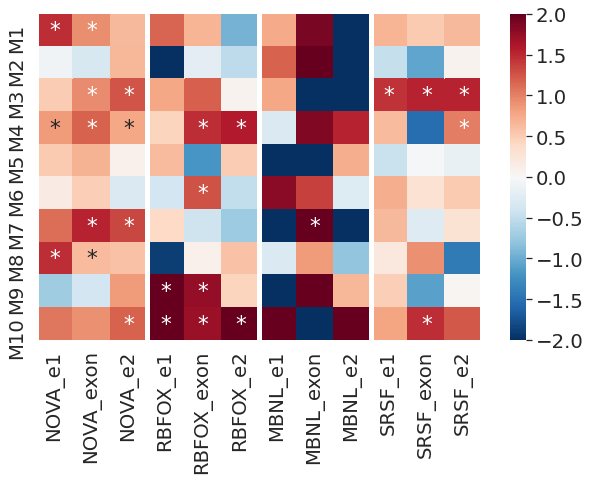

In [19]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
s1 = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
s2 = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_exon'] = ((s1+s2) > 0).astype(int)
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
s1 = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
s2 = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_exon'] = ((s1+s2) > 0).astype(int)
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
s1 = np.array(mouse_clip_peaks.loc[s1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
s2 = np.array(mouse_clip_peaks.loc[s2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
mouse_clip_families['MBNL_exon'] = ((s1+s2) > 0).astype(int)
mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
s1 = np.array(mouse_clip_peaks.loc[s1_exons, ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
s2 = np.array(mouse_clip_peaks.loc[s2_exons, ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_exon'] = ((s1+s2) > 0).astype(int)

mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = pd.read_csv('psix_3D/modules_3D.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]


hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 11):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 11)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(10,-10)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests


sns.set(font_scale=1.8)

fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 3):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

(2087, 12)


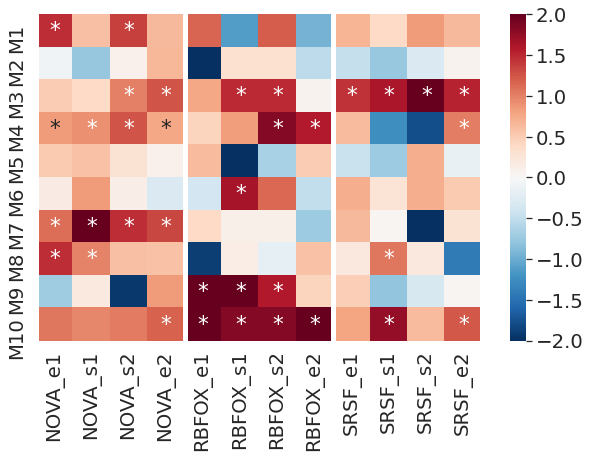

In [39]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']




mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = pd.read_csv('psix_3D/modules_3D.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]
# mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]

print(mouse_clip_families.shape)

# mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
# mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

# mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
# mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 11):
        enrichment = test_enrichment(mouse_clip_families.loc[psix_results.index, rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 11)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(10,-10)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests


sns.set(font_scale=1.8)

fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 4):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [18]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']

new_idx = [x[:-3] for x in mouse_clip_peaks.index if x[-3:] == '_e1']
mouse_clip_peaks_e1 = mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:] == '_e1']]
mouse_clip_peaks_s1 = mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:] == '_s1']]
mouse_clip_peaks_s2 = mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:] == '_s2']]
mouse_clip_peaks_e2 = mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:] == '_e2']]

mouse_clip_peaks_e1.index = new_idx
mouse_clip_peaks_s1.index = new_idx
mouse_clip_peaks_s2.index = new_idx
mouse_clip_peaks_e2.index = new_idx

mouse_clip_peaks_any = ((mouse_clip_peaks_e1 + mouse_clip_peaks_s1 + mouse_clip_peaks_s2 + mouse_clip_peaks_e2) > 0).astype(int)


modules = pd.read_csv('psix_3D/modules_3D.tab.gz', sep='\t', index_col=0).Module


remove = ['EZH2', 'AGO2', 'LIN28A', 'CIRBP', 'FMR1', 'TAF15', 'UPF1']
splicing_factors =  [x for x in mouse_clip_peaks_any.columns if x not in remove]

mouse_clip_peaks_any = mouse_clip_peaks_any.loc[psix_results.index, splicing_factors]

In [19]:
rbp_list = splicing_factors
module_pval_enrichment = pd.DataFrame()
for rbp in rbp_list:#mouse_clip_peaks_any.columns:
    mod_list = []
    for i in range(1, 11):
        mod_list.append(test_enrichment(mouse_clip_peaks_any.loc[psix_results.index, rbp], modules.index[(modules==i)])[0])
        
    module_pval_enrichment[rbp] = mod_list
    
module_pval_enrichment.index = ['Module_' + str(i) for i in range(1, 11)]
    
module_qval_enrichment = pd.DataFrame(multipletests(np.array(module_pval_enrichment).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(10,-30))
module_qval_enrichment.index = module_pval_enrichment.index
module_qval_enrichment.columns = module_pval_enrichment.columns
    


In [22]:
(module_qval_enrichment <= 0.05).sum(axis=0).sort_values()

PTBP1         0
CELF1         0
PABPC1        0
SRSF2         0
SRSF6         0
ELAVL1        0
SRSF3         0
RBM3          0
SRRM4         0
SRSF1         0
MBNL1         0
MBNL2         1
SRSF4         1
PTBP2         1
CELF4         1
SRSF5         1
MBNL1MBNL2    1
TARDBP        1
SRSF7         1
FUS           1
RBFOX2        2
RBFOX3        2
U2AF2         2
RBFOX1        3
NOVA2         3
NOVA1         5
dtype: int64

In [26]:
col_list = list(plt.get_cmap('tab20').colors)
colores = []
for rbp in module_qval_enrichment.columns:
    if np.sum(module_qval_enrichment[rbp] <= 0.05) == 0:
        colores.append('gray')
    else:
        if rbp[:4] == 'NOVA':
            colores.append(col_list[0])
        elif rbp[:5] == 'RBFOX':
            colores.append(col_list[2])
        elif rbp[:4] == 'MBNL':
            colores.append(col_list[4])
#         elif rbp[:4] == 'NOVA':
#             colores.append(col_list[6])
        elif rbp[:4] == 'SRSF':
            colores.append(col_list[6])
        elif rbp[:4] == 'CELF':
            colores.append(col_list[8])
        elif rbp[:5] == 'U2AF2':
            colores.append(col_list[10])
        elif rbp == 'TARDBP':
            colores.append(col_list[12]) 
        elif rbp == 'PTBP2':
            colores.append(col_list[16])
        elif rbp == 'FUS':
            colores.append(col_list[18])
    
    
    
    
    
    
# CELF4         1
# SRSF4         1
# MBNL2         1
# SRSF5         1
# MBNL1MBNL2    1
# TARDBP        1
# SRSF7         1
# FUS           1
# RBFOX2        2
# RBFOX3        2
# U2AF2         2
# RBFOX1        3
# NOVA2         3
# NOVA1         5

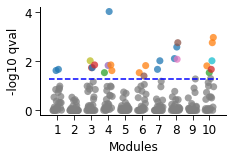

In [27]:
# colores = ['gray', 'gray', 'gray', 'gray', 'gray', 'blue', 'gray', 'gray', 'gray', 'red', 'gray', 'gray', 'skyblue', 'gold',
#            'gray', 'red', 'darkorange', 'gold', 'purple', 'indigo', 'blue', 'gray', 'gold', 'blue', 'gray']


# col_list = list(plt.get_cmap('tab10').colors)
# colores = ['gray', 'gray', 'gray', 'gray', 'gray', col_list[1], 'gray', 'gray', 'gray', col_list[0], 'gray', 'gray', 
#            col_list[2], col_list[3], 'gray', col_list[0], col_list[4], col_list[3], col_list[5], col_list[9], col_list[1], 
#            'gray', col_list[3], col_list[1], 'gray']

fig = plt.figure(figsize=(8/2.4, 5/2.5))
ax  = plt.subplot(1,1,1)
i = 1
for mod in module_qval_enrichment.index:
    li =  list(-np.log10(module_qval_enrichment).loc[mod])
    
    color_code = []
    for j in range(len(li)):
        if li[j] >= -np.log10(0.05):
            color_code.append(colores[j])
        else:
            color_code.append('gray')
            
    ax.scatter(np.linspace(i-0.25, i+0.25, 26),
#                np.random.uniform(i-0.2, i+0.2, 25), 
               li, s=50, c=color_code, alpha=0.75, linewidth=0)
    
#     ax.scatter(np.random.normal(i, 0.1, 25), li, label='mod ' + str(mod), s=20, c=color_code)
    
    i += 1
    
ax.plot([0.5, 10.5], [-np.log10(0.05), -np.log10(0.05)], 'b--')
ax.set_xlabel('Modules', size=12)


# ax.scatter([-3], [2], c=col_list[16], label='Fus')

# if rbp[:4] == 'NOVA':
#     colores.append(col_list[0])
# elif rbp[:5] == 'RBFOX':
#     colores.append(col_list[2])
# elif rbp[:4] == 'MBNL':
#     colores.append(col_list[4])
# #         elif rbp[:4] == 'NOVA':
# #             colores.append(col_list[6])
# elif rbp[:4] == 'SRSF':
#     colores.append(col_list[6])
# elif rbp[:4] == 'CELF':
#     colores.append(col_list[8])
# elif rbp[:5] == 'U2AF2':
#     colores.append(col_list[10])
# elif rbp == 'TARDBP':
#     colores.append(col_list[12]) 
# elif rbp == 'FUS':
#     colores.append(col_list[18])


ax.set_xlim([0, 11])
ax.set_xticks(range(1, 11))
ax.tick_params(labelsize=12, length=5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('-log10 qval', size=12)
# plt.legend()

# plt.show()
plt.savefig('plots/module_enrichment.png', bbox_inches='tight', res=20000, dpi =2000)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

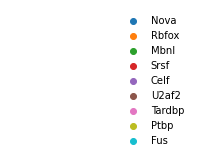

In [29]:
fig = plt.figure(figsize=(8/2.4, 5/2.5))
ax  = plt.subplot(1,1,1)

ax.scatter([-3], [2], c=col_list[0], label='Nova')
ax.scatter([-3], [2], c=col_list[2], label='Rbfox')
ax.scatter([-3], [2], c=col_list[4], label='Mbnl')
ax.scatter([-3], [2], c=col_list[6], label='Srsf')
ax.scatter([-3], [2], c=col_list[8], label='Celf')
ax.scatter([-3], [2], c=col_list[10], label='U2af2')
ax.scatter([-3], [2], c=col_list[12], label='Tardbp')
ax.scatter([-3], [2], c=col_list[16], label='Ptbp')
ax.scatter([-3], [2], c=col_list[18], label='Fus')

ax.set_xlim([0,1])
ax.set_xticks([])
ax.set_yticks([])
# ax.tick_params(labelsize=12, length=5)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.legend(frameon=False)

# plt.show()

plt.savefig('plots/module_enrichment_colors_legend.png', bbox_inches='tight', res=20000, dpi =2000)

100%|██████████| 12/12 [00:00<00:00, 54.61it/s]


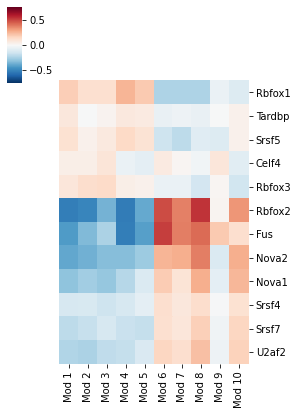

In [71]:
module_avg = pd.DataFrame()


sf_list = ['Tardbp', 'Srsf4', 'Srsf7', 'Celf4', 'Srsf5', 'Rbfox2', 'Rbfox3', 'U2af2', 'Rbfox1', 'Nova2', 'Fus', 'Nova1']

sf_list = [x for x in sf_list if x in norm_expression.index]

for mod in range(1, 11):
    module_avg['module_' + str(mod)] = np.nanmean(zscore(psi.loc[modules.index[modules == mod]], axis=1, 
                                             nan_policy='omit'), axis=0)
    
module_avg.index = psi.columns
module_avg = module_avg.T


module_avg_corr = pd.DataFrame(np.zeros((len(sf_list), len(module_avg.index))), 
                               index = sf_list, columns = module_avg.index)
for sf in tqdm(sf_list):
    for mod in module_avg.index:
        module_avg_corr.loc[sf, mod] = pearsonr(module_avg.loc[mod],
                                                norm_expression.loc[sf, module_avg.columns]
        )[0]
        
mod_order = ['module_1', 'module_2', 'module_3', 'module_4', 'module_5',
             'module_6', 'module_7', 'module_8', 'module_9', 'module_10']

mod_cor = module_avg_corr.loc[sf_list, mod_order]
mod_cor.columns = ['Mod 1', 'Mod 2', 'Mod 3', 'Mod 4', 'Mod 5',
             'Mod 6', 'Mod 7', 'Mod 8', 'Mod 9', 'Mod 10']

cg = sns.clustermap(mod_cor, 
               col_cluster=False,
#               row_colors = gene_mod_colors, 
               row_cluster=True, vmin=-0.75, vmax=0.75, cmap='RdBu_r', figsize=(10/2.4, 14/2.4))

cg.ax_row_dendrogram.set_visible(False)

plt.show()
# plt.savefig('plots/module_correlations.png', bbox_inches='tight', res=20000, dpi =2000)

In [28]:
def test_enrichment_multiplier(binding, exon_cluster, x = 1):
    M = len(binding)*x
    n = binding.sum()
    N = len(exon_cluster)*x
    k = binding.loc[exon_cluster].sum()
    p_depleted, p_enriched = hyper_test(M, n, N, k)
    
    enrichment = (k/N)/(n/M)
    
    if enrichment == 0:
        log_enrich = -3
    else:
        log_enrich = np.log2(enrichment)
        
    
    return p_enriched, p_depleted, log_enrich

from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

In [30]:
mouse_clip_peaks_all = (mouse_clip_peaks_e1 + mouse_clip_peaks_s1 + mouse_clip_peaks_s2 + mouse_clip_peaks_e2)


rbp_list = splicing_factors
module_pval_enrichment = pd.DataFrame()
for rbp in rbp_list:#mouse_clip_peaks_all.columns:
    mod_list = []
    for i in range(1, 11):
        mod_list.append(test_enrichment_multiplier(mouse_clip_peaks_all[rbp], modules.index[(modules==i)], 4)[0])
        
    module_pval_enrichment[rbp] = mod_list
    
module_pval_enrichment.index = ['Module_' + str(i) for i in range(1, 11)]
    
module_qval_enrichment = pd.DataFrame(multipletests(np.array(module_pval_enrichment).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(10,-30))
module_qval_enrichment.index = module_pval_enrichment.index
module_qval_enrichment.columns = module_pval_enrichment.columns
    


Text(0, 0.5, 'enrichent -log10 qval')

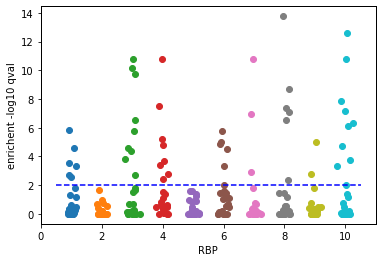

In [31]:
i = 1
for mod in module_qval_enrichment.index:
    li =  list(-np.log10(module_qval_enrichment).loc[mod])
    plt.scatter(np.random.normal(i, 0.1, 25), li, label='mod ' + str(mod))
    
    i += 1
    
plt.plot([0.5, 10.5], [-np.log10(0.01), -np.log10(0.01)], 'b--')
plt.xlabel('RBP')
plt.ylabel('enrichent -log10 qval')
# plt.legend()

Text(0, 0.5, 'enrichent -log10 qval')

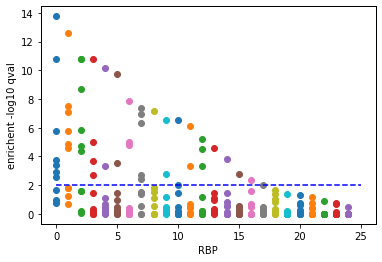

In [32]:
i = 0
for rbp in (-np.log10(module_qval_enrichment).min(axis=0).sort_values()).index:
    li =  list(-np.log10(module_qval_enrichment)[rbp])
    plt.scatter([i]*10, li)
    
    i += 1
    
plt.plot([0, 25], [-np.log10(0.01), -np.log10(0.01)], 'b--')
plt.xlabel('RBP')
plt.ylabel('enrichent -log10 qval')

In [33]:
(-np.log10(module_qval_enrichment).min(axis=0).sort_values()).index

Index(['U2AF2', 'FUS', 'NOVA1', 'RBFOX2', 'SRSF6', 'SRSF4', 'RBFOX1', 'NOVA2',
       'SRSF7', 'TARDBP', 'SRSF1', 'RBFOX3', 'CELF4', 'SRSF2', 'SRSF5',
       'MBNL1MBNL2', 'SRRM4', 'MBNL2', 'SRSF3', 'CELF1', 'RBM3', 'PABPC1',
       'ELAVL1', 'MBNL1', 'PTBP1'],
      dtype='object')

In [50]:
rbp_sorted = module_pval_enrichment.mean().sort_values().index[::-1]

In [51]:
module_pval_enrichment[rbp_sorted]

,NOVA1,U2AF2,FUS,NOVA2,RBFOX1,RBFOX2,TARDBP,LIN28A,SRSF4,CELF4,...,SRSF2,RBM3,PABPC1,MBNL1,CELF1,FMR1,TAF15,UPF1,ELAVL1,PTBP1
Module_1,3.989803,2.894790,3.215343,3.358709,0.903010,0.826672,1.134513,1.628804,1.717941,0.197398,...,0.420375,0.500903,1.286704,-0.000000,0.476360,-0.000000,-0.000000,1.582736,-0.000000,-0.000000
Module_2,0.220211,1.537594,1.201394,0.776935,-0.000000,0.070704,0.632319,0.573704,-0.000000,-0.000000,...,1.059299,-0.000000,0.888396,1.245083,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
Module_3,4.111873,3.459202,1.952032,2.326356,0.149381,1.184222,0.182533,0.333964,4.242220,0.592802,...,0.757611,0.506759,-0.000000,0.391916,-0.000000,-0.000000,0.318593,-0.000000,-0.000000,-0.000000
Module_4,8.975002,2.840126,3.921288,2.162666,3.046046,3.214663,0.493454,4.528948,0.786174,3.759068,...,0.402184,0.742565,0.596863,-0.000000,2.055750,0.944860,0.815008,-0.000000,-0.000000,-0.000000
Module_5,2.291908,1.540765,1.409518,1.952099,0.268284,0.335982,0.072791,0.596535,0.724590,0.371861,...,0.119083,0.372364,-0.000000,-0.000000,-0.000000,0.470003,0.607330,-0.000000,1.413853,-0.000000
Module_6,0.975784,4.194255,3.666609,0.161214,3.433149,0.980864,0.382191,1.504965,1.207025,1.852903,...,0.719450,-0.000000,0.147127,0.270060,0.350082,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
Module_7,4.659043,2.909450,3.455560,3.394516,1.056968,0.488692,0.902499,0.445148,-0.000000,0.682198,...,0.007504,-0.000000,0.285039,1.136634,-0.000000,0.666611,-0.000000,-0.000000,-0.000000,-0.000000
Module_8,6.381882,7.530374,2.438280,4.787185,0.321740,0.508302,4.869923,0.213453,0.777689,1.262953,...,0.894144,0.260968,0.078885,0.173991,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
Module_9,0.499909,0.550681,2.369736,0.232756,0.619702,2.291723,2.182616,0.553155,0.735308,-0.000000,...,0.084403,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.846764
Module_10,3.195380,1.895578,5.025785,2.544636,5.448883,4.728467,1.538047,0.864879,0.721274,1.389998,...,0.274429,1.473461,0.314986,-0.000000,-0.000000,0.705078,1.039729,0.744245,-0.000000,-0.000000


(2087, 12)


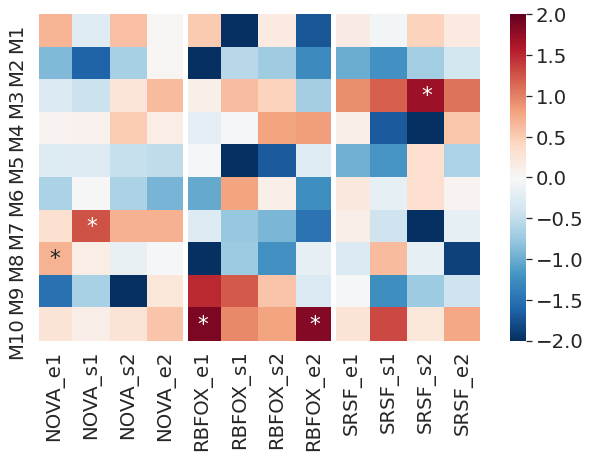

In [16]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']


mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = pd.read_csv('psix_3D/modules_3D.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]
# mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]

print(mouse_clip_families.shape)

# mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
# mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

# mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
# mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 11):
        enrichment = test_enrichment(mouse_clip_families.loc[modules.index, rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 11)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(10,-10)<=0.15)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests


sns.set(font_scale=1.8)

fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 4):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()